Import Libraries

In [2]:
# Import Libraries
import os
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score,roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

Define Dataset Paths

In [3]:
# Define dataset directories
base_path = r"C:\Users\mathe\Documents\deepfake_detection"
train_dir = os.path.join(base_path, "frames", "train")
val_dir = os.path.join(base_path, "frames", "val")
test_dir = os.path.join(base_path, "frames", "test")

Data Generators

In [4]:
# Data generators with reduced input size (150x150)
train_datagen = ImageDataGenerator(rescale=1.0 / 255, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(150, 150), batch_size=16, class_mode='binary'
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(150, 150), batch_size=16, class_mode='binary'
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(150, 150), batch_size=16, class_mode='binary', shuffle=False
)

Found 7394 images belonging to 2 classes.
Found 2113 images belonging to 2 classes.
Found 1058 images belonging to 2 classes.


Load Pre-Trained Model

In [5]:
# Load pre-trained Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze all layers in the base model initially
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)  # Reduced dropout for faster training
x = Dense(64, activation='relu')(x)  # Smaller dense layer
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [2]:
import tensorflow as tf
tf.keras.backend.clear_session()

Train the Classification Head

In [6]:
# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# Train only the classification head for 5 epochs
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[early_stopping, reduce_lr]
)

C:\Users\mathe\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
463/463 ━━━━━━━━━━━━━━━━━━━━ 297s 634ms/step - accuracy: 0.5910 - loss: 0.6729 - val_accuracy: 0.6730 - val_loss: 0.5965 - learning_rate: 1.0000e-04
Epoch 2/5
463/463 ━━━━━━━━━━━━━━━━━━━━ 264s 569ms/step - accuracy: 0.6746 - loss: 0.5962 - val_accuracy: 0.6952 - val_loss: 0.5712 - learning_rate: 1.0000e-04
Epoch 3/5
463/463 ━━━━━━━━━━━━━━━━━━━━ 266s 575ms/step - accuracy: 0.6793 - loss: 0.5843 - val_accuracy: 0.7151 - val_loss: 0.5549 - learning_rate: 1.0000e-04
Epoch 4/5
463/463 ━━━━━━━━━━━━━━━━━━━━ 2235s 5s/step - accuracy: 0.6940 - loss: 0.5662 - val_accuracy: 0.6985 - val_loss: 0.5537 - learning_rate: 1.0000e-04
Epoch 5/5
463/463 ━━━━━━━━━━━━━━━━━━━━ 268s 579ms/step - accuracy: 0.7199 - loss: 0.5388 - val_accuracy: 0.7175 - val_loss: 0.5382 - learning_rate: 1.0000e-04


Fine-Tune the Model

In [7]:
# Unfreeze last 10 layers
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Recompile with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune the model for 5 more epochs
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/5
463/463 ━━━━━━━━━━━━━━━━━━━━ 22934s 50s/step - accuracy: 0.6684 - loss: 0.6072 - val_accuracy: 0.7231 - val_loss: 0.5416 - learning_rate: 1.0000e-05
Epoch 2/5
463/463 ━━━━━━━━━━━━━━━━━━━━ 328s 709ms/step - accuracy: 0.6932 - loss: 0.5564 - val_accuracy: 0.7250 - val_loss: 0.5253 - learning_rate: 1.0000e-05
Epoch 3/5
463/463 ━━━━━━━━━━━━━━━━━━━━ 319s 689ms/step - accuracy: 0.7277 - loss: 0.5260 - val_accuracy: 0.7392 - val_loss: 0.5087 - learning_rate: 1.0000e-05
Epoch 4/5
463/463 ━━━━━━━━━━━━━━━━━━━━ 324s 700ms/step - accuracy: 0.7306 - loss: 0.5110 - val_accuracy: 0.7435 - val_loss: 0.4970 - learning_rate: 1.0000e-05
Epoch 5/5
463/463 ━━━━━━━━━━━━━━━━━━━━ 321s 693ms/step - accuracy: 0.7496 - loss: 0.5024 - val_accuracy: 0.7468 - val_loss: 0.4904 - learning_rate: 1.0000e-05


In [62]:
model_path = os.path.join(base_path, "models", "fine_tuned_xception.keras")
model.save(model_path)  # Save in Keras format
model.save(model_path, include_optimizer=False)

Visualize Training Performance

In [65]:
# Evaluate on the test set
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Custom metrics: Confusion matrix, precision, recall, F1-score, and ROC-AUC
y_true = test_generator.classes
y_pred = (model.predict(test_generator) > 0.5).astype('int')

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# ROC-AUC
roc_auc = roc_auc_score(y_true, y_pred)
print(f"ROC-AUC: {roc_auc}")



67/67 ━━━━━━━━━━━━━━━━━━━━ 31s 458ms/step - accuracy: 0.7433 - loss: 0.5923
Test Loss: 0.7509865760803223
Test Accuracy: 0.48771265149116516
67/67 ━━━━━━━━━━━━━━━━━━━━ 33s 494ms/step
Confusion Matrix:
[[420  64]
 [478  96]]
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.87      0.61       484
           1       0.60      0.17      0.26       574

    accuracy                           0.49      1058
   macro avg       0.53      0.52      0.43      1058
weighted avg       0.54      0.49      0.42      1058

ROC-AUC: 0.5175079909004521


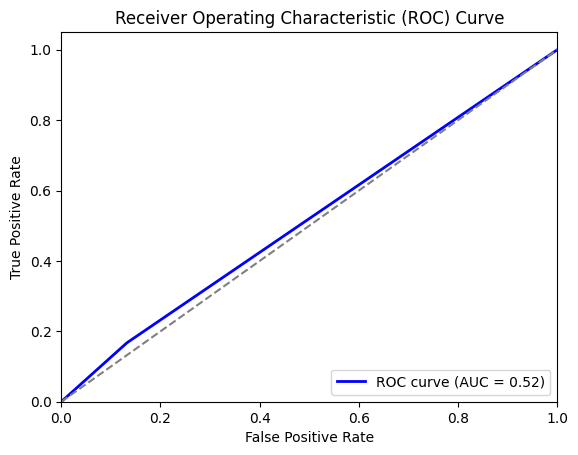

In [64]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

2 - optimized set of fine-tuning values and code for improving scores

In [21]:
# Load the Pre-Trained Model
model = load_model(r"C:\Users\mathe\Documents\deepfake_detection\models\fine_tuned_xception.keras")
print("Model loaded successfully!")

Model loaded successfully!


In [23]:
# Freeze All Layers Initially
for layer in model.layers:
    layer.trainable = False

In [24]:
# Unfreeze the Last 5 Layers for Fine-Tuning
for layer in model.layers[-5:]:
    layer.trainable = True
print("Last 5 layers unfrozen for fine-tuning.")

Last 5 layers unfrozen for fine-tuning.


In [26]:
from tensorflow.keras.optimizers import RMSprop
# Compile the Model
model.compile(
    optimizer=RMSprop(learning_rate=5e-5),  # Slightly larger learning rate for quick convergence
    loss='binary_crossentropy',
    metrics=['accuracy']
)
print("Model compiled successfully!")

Model compiled successfully!


In [48]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Preparation
train_datagen = ImageDataGenerator(rescale=1.0 / 255, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Correct dataset paths
train_dir = r"C:\Users\mathe\Documents\DEEPFAKE_DETECTION\frames\train"
val_dir = r"C:\Users\mathe\Documents\DEEPFAKE_DETECTION\frames\val"

# Data Generators
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(150, 150), batch_size=32, class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(150, 150), batch_size=32, class_mode='binary'
)

print("Data generators created successfully!")

Found 7394 images belonging to 2 classes.
Found 2113 images belonging to 2 classes.
Data generators created successfully!


In [35]:
# Fine-Tune the Model
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=3,  # Reduced epochs for faster training
    callbacks=[early_stopping, reduce_lr]
)
print("Fine-tuning complete!")



Epoch 1/3
232/232 ━━━━━━━━━━━━━━━━━━━━ 292s 1s/step - accuracy: 0.7665 - loss: 0.4507 - val_accuracy: 0.7440 - val_loss: 0.4845 - learning_rate: 2.5000e-05
Epoch 2/3
232/232 ━━━━━━━━━━━━━━━━━━━━ 291s 1s/step - accuracy: 0.7726 - loss: 0.4510 - val_accuracy: 0.7402 - val_loss: 0.4840 - learning_rate: 2.5000e-05
Epoch 3/3
232/232 ━━━━━━━━━━━━━━━━━━━━ 290s 1s/step - accuracy: 0.7638 - loss: 0.4578 - val_accuracy: 0.7473 - val_loss: 0.4836 - learning_rate: 2.5000e-05
Fine-tuning complete!


In [46]:
model_path = os.path.join(base_path, "models", "fine_tuned_xception_second.keras")
model.save(model_path)  # Save in Keras format
model.save(model_path, include_optimizer=False)

In [52]:
# Define the test data generator
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_dir = r"C:\Users\mathe\Documents\DEEPFAKE_DETECTION\frames\val"

# Create the test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=16,
    class_mode='binary',
    shuffle=False  # Important: Do not shuffle to align predictions with labels
)

Found 2113 images belonging to 2 classes.


In [53]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

C:\Users\mathe\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


133/133 ━━━━━━━━━━━━━━━━━━━━ 68s 487ms/step - accuracy: 0.7605 - loss: 0.5056
Test Loss: 0.48358607292175293
Test Accuracy: 0.7472787499427795


In [54]:
# Get predictions
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary classes

# Get true labels
y_true = test_generator.classes  # True labels
print("Predictions generated successfully!")

# Generate classification report
report = classification_report(y_true, y_pred_classes, target_names=["Real", "Fake"])
print("Classification Report:\n", report)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

133/133 ━━━━━━━━━━━━━━━━━━━━ 64s 470ms/step
Predictions generated successfully!
Classification Report:
               precision    recall  f1-score   support

        Real       0.69      0.81      0.75       967
        Fake       0.81      0.69      0.75      1146

    accuracy                           0.75      2113
   macro avg       0.75      0.75      0.75      2113
weighted avg       0.76      0.75      0.75      2113

Confusion Matrix:
 [[783 184]
 [350 796]]


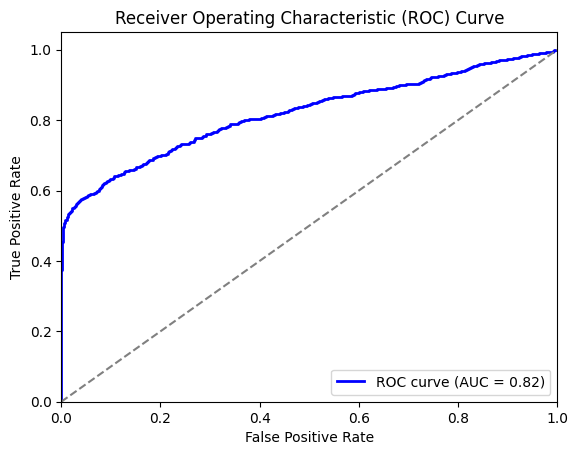

In [55]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()